# The Best Location for a New Daycare in Fairfax County, Virginia

##### *By Gustave Muhoza*
July 2020

## I. Introduction

### I.1. Background and Project Motivation

In the last two decades, the child care services industry has been steadily growing. In 2019, for example, it was estimated that this industry was bringing in 47 billions dollars in revenues [(1)](https://blogs.edweek.org/edweek/early_years/2019/02/child_care_packs_nearly_100_billion_economic_impact_report_finds.html). Although child care services is ranked as the 2nd best franchise in the United States by FranData, a Franchise Market Research company[(2)](https://franserve.com/2020/02/the-top-franchising-categories-of-2020/), the vast majority of child care services is still provided by family members or within a home and often without any monetary cost [(3)](https://www.childtrends.org/nearly-30-percent-of-infants-and-toddlers-attend-home-based-child-care-as-their-primary-arrangement). Clearly, there is a room for new providers. Given this size and steady growth, providing childcare services can be fulfilling not just for the type of services provided--serving children is a worthy goal in its own right--but also because of financial sustainability. However, as is the case for many other small businesses, long term financial sustainability is not guaranteed: starting a child care services business requires extensive market research.

### I.2. The Business Problem

In this project, I explore one way data science can help answer perhaps the main question for any in-person, service business market research, namely, the question of location. Specifically, I present the case of a person in Fairfax County, Virginia who is the process of making a decision about the neighborhood in which to establish a new daycare. Using Census Bureau, Fairfax County, and Foursquare data, my goal is to answer the following question: **Which Fairfax neighborhoods present the best opportunity for a new daycare?**

### I.3. Objectives and Possible Application

In answering the above question, I aim to present at most two neighborhoods with population characteristics that indicate need for additional daycares. Results from the analysis presented here can be useful not just for daycare businesses, but also othe similar small businesses in the service industry. 

## II. The Data

### II.1. Data Description

Choosing a daycare location may depend on other factors including the type of daycare, time services will be provided, recent marriages in the area, and many other demographic factors (see [US Small Business Administration](https://www.sba.gov/sites/default/files/files/pub_mp29.pdf)). I explore these factors including the geographic concentration of children ages 0 to 4, family structure, the number of daycares available in the area, and income level in the neighborhood. I base my analysis and recommendations on the following data:

- **Census Designated Places (CDPs) data**: The data is available through [Fairfax County Open Geospatial Data](https://www.fairfaxcounty.gov/maps/open-geospatial-data) and is provided in many formats. I chose the csv version. In addition to the cdps names that will be used as neighborhoods for the purpose of my analysis, this data provides latitudes and longitudes of the different neighborhooods for mapping purposes and for obtaining nearby daycares. Knowledge of the area confirms that Fairfax County CDPs can indeed be considered neighborhoods.

- **Census Designated Places (CDPs) data (2)**: This file, which is available in several formats through [data.gov](https://catalog.data.gov/dataset/census-2010-designated-place-c3875) replaced the file above because the file above did not have shape coordinates for mapping needs. This shape file was downloaded in .shp format and transformed into a dataframe and then csv thinking it would make it easier to access. Unfortunately, the geometry data format was not good, so decided to do more study on IBM cloud and was able to figure out how to install geopandas and import to read geojson file. This allowed me to also read it directly from Fairfax GIS site in its geojson format which included a well-formatted geometry field with Multipolygon coordinates representing all Fairfax CDPs. 

- **Census 2010 ZCTA to Place Relationship File**: This csv file is provided by [the US Census Bureau](http://www2.census.gov/geo/docs/maps-data/data/rel/zcta_place_rel_10.txt?#) and contains population data by zip code tabulation area (ZCTA) and how the ZCTAs match county's CDPs. Please also note that for simplification, I use “Zip Code” (postal code) and “ZCTA” interchangeably even though I am aware of issues that may result [(5)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1762013/). Lack of geographic precision, however, should not undermine this analysis because a daycare established in one geographic area can provide services to children residing in other geographic areas. This file will make it possible to represent businesses by zipcode (approximately) and neighborhood at the same time. I read this relationship file from the Census Bureau and merge it with the designated places data from Fairfax County using their shared geoid. The result will be a zip code with the corresponding neighborhoods.

- **American Community Survey Age and Sex (2018 5-Year Estimates Data)**: I obtained this csv data by exploring [the US Census Bureau Explore Census Data](https://data.census.gov/cedsci/) many tables. This file has a count of children under 5 data by census designated place. Due to time constraint, I was not able to learn the Census API to obtain the file programmatically. I downloaded the file and saved it on my pc and will read it with python later.

- **American Community Survey Comparative Economic Characteristics (2018 5-Year Estimates)**: This csv data data avaible for dowload at [the US Census Bureau Explore Census Data](https://data.census.gov/cedsci/). The key data from this table is the number of households with children under 6 and in which all parents are in the labor force. 

- **Foursquare Data**: Using Foursquare Places API's explore endpoint and the daycare category (4f4532974b9074f6e4fb0104), I rely on the census data above to pull a list of daycares by each neighborhood and zip code.  

### II.2. Neighborhood Geospatial Data Acquisition and Proparation

In [1]:
import folium

In [2]:
# Import the needed libraries for processing Foursquare data
import requests # To handle requests
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns #for plotting especially regression plots if needed
import matplotlib.pyplot as plt # for general plotting

%matplotlib inline

import folium #For mapping

In [4]:
#Obtain census designated (cdps) places which I use to approximate well with Fairfax neighborhoods
cdps= 'http://data-fairfaxcountygis.opendata.arcgis.com/datasets/64191f811f284007b27c6d29a9266411_3.csv' #Variable path to the online file
ffx_neighborhoods1=pd.read_csv(cdps)
ffx_neighborhoods1.head()

FID  STATEFP  PLACEFP  PLACENS    GEOID                 NAME  \
0    1       51    36648  2390244  5136648              Herndon   
1    2       51    17376  2390803  5117376              Clifton   
2    3       51    81072  2391461  5181072               Vienna   
3    4       51     1912  2389138  5101912            Annandale   
4    5       51     4088  2389166  5104088  Bailey's Crossroads   

                  NAMELSAD  LSAD CLASSFP PCICBSA PCINECTA  MTFCC FUNCSTAT  \
0             Herndon town    43      C1       N        N  G4110        A   
1             Clifton town    43      C1       N        N  G4110        A   
2              Vienna town    43      C1       N        N  G4110        A   
3            Annandale CDP    57      U1       N        N  G4210        S   
4  Bailey's Crossroads CDP    57      U2       N        N  G4210        S   

      ALAND  AWATER   INTPTLAT   INTPTLON  SHAPE_Length  SHAPE_Area  
0  11076010   17595  38.970412 -77.387073      0.146095    0.001153  
1    635487   10116  38.780128 -77.385990      0.033160    0.000067  
2  11415119   17193  38.898576 -77.258323      0.202853    0.001187  
3  20348939   30218  38.832801 -77.196229      0.236998    0.002114  
4   5311343     717  38.848262 -77.131959      0.124045    0.000551

In [5]:
#Save it locally just in case
ffx_neighborhoods1.to_csv('cdps1.csv')

When I initially read the file above from Fairfax County GIS page, I did not realize that there was no column for the polygon geometry. I attempted to read this file or upload into Watson without success. My workaround was to download the file on my pc, read it using shapefile and follow these [directions](https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f) to convert it into a pandas dataframe. I then created a csv version of the dataframe which I uploaded here. After trying troubleshooting issues and realizing that others have had installation issues on Watson, I decided to move back to the Skills Network Labs. 

In [6]:
ffx_neighborhoods= pd.read_csv('ffx_cdps.csv')
ffx_neighborhoods.head()

Unnamed: 0  FID  STATEFP  PLACEFP  PLACENS    GEOID                 NAME  \
0           0    1       51    36648  2390244  5136648              Herndon   
1           1    2       51    17376  2390803  5117376              Clifton   
2           2    3       51    81072  2391461  5181072               Vienna   
3           3    4       51     1912  2389138  5101912            Annandale   
4           4    5       51     4088  2389166  5104088  Bailey's Crossroads   

                  NAMELSAD  LSAD CLASSFP  ... PCINECTA  MTFCC FUNCSTAT  \
0             Herndon town    43      C1  ...        N  G4110        A   
1             Clifton town    43      C1  ...        N  G4110        A   
2              Vienna town    43      C1  ...        N  G4110        A   
3            Annandale CDP    57      U1  ...        N  G4210        S   
4  Bailey's Crossroads CDP    57      U2  ...        N  G4210        S   

        ALAND   AWATER   INTPTLAT   INTPTLON  SHAPE_Leng  SHAPE_Area  \
0  11076010.0  17595.0  38.970412 -77.387073    0.146095    0.001153   
1    635487.0  10116.0  38.780128 -77.385990    0.033160    0.000067   
2  11415119.0  17193.0  38.898576 -77.258323    0.202853    0.001187   
3  20348939.0  30218.0  38.832801 -77.196229    0.236998    0.002114   
4   5311343.0    717.0  38.848262 -77.131959    0.124045    0.000551   

                                              coords  
0  [(-77.41359241699996, 38.97163478600004), (-77...  
1  [(-77.39284639799996, 38.78154174900004), (-77...  
2  [(-77.28476537199998, 38.900528777000034), (-7...  
3  [(-77.22214534799997, 38.820930763000035), (-7...  
4  [(-77.14751432699995, 38.85212377200003), (-77...  

[5 rows x 21 columns]

In [7]:
#Make sure I got the neighborhoods right
print('For the purpose of this analysis, Fairfax has {} neighborhoods each corresponding to a cdp.'.format(
       len(ffx_neighborhoods['NAME'].unique()),
       ffx_neighborhoods.shape[0]
   )
)


For the purpose of this analysis, Fairfax has 61 neighborhoods each corresponding to a cdp.


### II.2.1. Initial Neighborhood Vizualization

Just to have an initial mental picture of the 61 neighborhoods, below I map them using folium

In [8]:
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

     |████████████████████████████████| 112kB 10.0MB/s eta 0:00:01


In [9]:
#Get Fairfax County latitude and longitude values

address = 'Fairfax County, VA'

geolocator = Nominatim(user_agent="ffx_citizen")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Fairfax County are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Fairfax County are 38.8156356, -77.2836849.


In [10]:
# Create a Fairfax map  with marked neighborhoods
map_ffx = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(ffx_neighborhoods['INTPTLAT'], ffx_neighborhoods['INTPTLON'], ffx_neighborhoods['NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ffx)  
    
map_ffx

The blue circles successfully identify all 61 Fairfax neighborhood. In the next section, I obtain additional neighborhood characteristics from the Census Bureau. Where it is straightforward, I read the data directly from the Census Bureau's website; otherwise, I search for the data and download it onto my pc for easier access. Each for files read directly, I make sure I save them locally as well just in case there is a problem with the API or the Internet later on.

### II.3. Population Characteristics Data

Please note that in order to obtain as much information as possible, I am mostly using the 5 year average with the most recent estimates being from 2018

In [11]:
#Obtain the file with relationship of zip to county places from the US Census Bureau
zip_c_relat = 'https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_place_rel_10.txt?#'

zip_c_relat_df = pd.read_csv(zip_c_relat)
zip_c_relat_df.head()

ZCTA5  STATE  PLACE CLASSFP    GEOID  POPPT  HUPT   AREAPT  AREALANDPT  \
0    601     72    358      U1  7200358   4406  1968  1942319     1942319   
1    602     72    616      U1  7200616   3212  1648   955285      955285   
2    602     72  47873      U1  7247873   2886  1205  4238649     4238649   
3    603     72    745      U1  7200745  13310  7479  6568015     6535128   
4    603     72   9689      U1  7209689   3334  1520  1299789     1299789   

    ZPOP  ...   PLAREA  PLAREALAND  ZPOPPCT  ZHUPCT  ZAREAPCT  ZAREALANDPCT  \
0  18570  ...  1942319     1942319    23.73   25.41      1.16          1.17   
1  41520  ...   955285      955285     7.74    9.12      1.14          1.20   
2  41520  ...  4238649     4238649     6.95    6.67      5.06          5.35   
3  54689  ...  8053806     6535128    24.34   29.15      8.00          7.98   
4  54689  ...  1299789     1299789     6.10    5.93      1.58          1.59   

   PLPOPPCT  PLHUPCT  PLAREAPCT  PLAREALANDPCT  
0     100.0    100.0     100.00          100.0  
1     100.0    100.0     100.00          100.0  
2     100.0    100.0     100.00          100.0  
3     100.0    100.0      81.55          100.0  
4     100.0    100.0     100.00          100.0  

[5 rows x 25 columns]

In [12]:
#Save it locally just in case
zip_c_relat_df.to_csv('cdps_zip.csv')

In [13]:
# Merge the dataframes to obtain the zip code corresponding to the Fairfax designated places

zip_c__df = pd.merge(zip_c_relat_df,ffx_neighborhoods[['GEOID','NAME','INTPTLAT','INTPTLON']], on='GEOID')
zip_c__df.head()

ZCTA5  STATE  PLACE CLASSFP    GEOID  POPPT   HUPT    AREAPT  AREALANDPT  \
0  20120     51  14440      U1  5114440  34916  12436  16784359    16592384   
1  20121     51  14440      U1  5114440  27014  10037   9528403     9458236   
2  20124     51  14440      U1  5114440   8733   2896   4588735     4548504   
3  20151     51  14440      U1  5114440    472    147    285215      283931   
4  22030     51  14440      U1  5114440      0      0      2135        2135   

    ZPOP  ...  ZHUPCT  ZAREAPCT  ZAREALANDPCT  PLPOPPCT  PLHUPCT  PLAREAPCT  \
0  40695  ...   87.47     37.15         37.30     49.08    48.74      53.82   
1  27988  ...   96.91     40.59         42.25     37.98    39.34      30.55   
2  14857  ...   57.32      8.08          8.26     12.28    11.35      14.71   
3  21374  ...    2.15      0.70          0.71      0.66     0.58       0.91   
4  55066  ...    0.00      0.00          0.00      0.00     0.00       0.01   

   PLAREALANDPCT         NAME  INTPTLAT   INTPTLON  
0          53.72  Centreville  38.84065 -77.438462  
1          30.62  Centreville  38.84065 -77.438462  
2          14.73  Centreville  38.84065 -77.438462  
3           0.92  Centreville  38.84065 -77.438462  
4           0.01  Centreville  38.84065 -77.438462  

[5 rows x 28 columns]

In [14]:
#Examine the size
zip_c__df.shape

(154, 28)

In [15]:
#Read data on population by age to extract number of children under 5

df_data_children = pd.read_csv('VirginiaPlacesAgeandSex2018.csv')
df_data_children.head()

GEO_ID                     NAME  \
0                id     Geographic Area Name   
1  1600000US5100148  Abingdon town, Virginia   
2  1600000US5100180   Accomac town, Virginia   
3  1600000US5100468     Adwolf CDP, Virginia   
4  1600000US5100724   Alberta town, Virginia   

                      S0101_C01_001E  \
0  Estimate!!Total!!Total population   
1                               8020   
2                                451   
3                               1673   
4                                350   

                                 S0101_C01_001M  \
0  Margin of Error!!Total MOE!!Total population   
1                                            24   
2                                            92   
3                                           249   
4                                            94   

                        S0101_C02_001E  \
0  Estimate!!Percent!!Total population   
1                                  (X)   
2                                  (X)   
3                                  (X)   
4                                  (X)   

                                   S0101_C02_001M  \
0  Margin of Error!!Percent MOE!!Total population   
1                                             (X)   
2                                             (X)   
3                                             (X)   
4                                             (X)   

                     S0101_C03_001E  \
0  Estimate!!Male!!Total population   
1                              3882   
2                               254   
3                               813   
4                               175   

                                S0101_C03_001M  \
0  Margin of Error!!Male MOE!!Total population   
1                                          212   
2                                           60   
3                                          177   
4                                           54   

                             S0101_C04_001E  \
0  Estimate!!Percent Male!!Total population   
1                                       (X)   
2                                       (X)   
3                                       (X)   
4                                       (X)   

                                      S0101_C04_001M  ...  \
0  Margin of Error!!Percent Male MOE!!Total popul...  ...   
1                                                (X)  ...   
2                                                (X)  ...   
3                                                (X)  ...   
4                                                (X)  ...   

                              S0101_C02_038E  \
0  Estimate!!Percent!!PERCENT ALLOCATED!!Age   
1                                        0.5   
2                                        0.4   
3                                          0   
4                                          0   

                                      S0101_C02_038M  \
0  Margin of Error!!Percent MOE!!PERCENT ALLOCATE...   
1                                                (X)   
2                                                (X)   
3                                                (X)   
4                                                (X)   

                           S0101_C03_038E  \
0  Estimate!!Male!!PERCENT ALLOCATED!!Age   
1                                     (X)   
2                                     (X)   
3                                     (X)   
4                                     (X)   

                                      S0101_C03_038M  \
0  Margin of Error!!Male MOE!!PERCENT ALLOCATED!!Age   
1                                                (X)   
2                                                (X)   
3                                                (X)   
4                                                (X)   

                                   S0101_C04_038E  \
0  Estimate!!Percent Male!!PERCENT ALLOCATED!!Age   
1                                             (X)   
2                        

On this file, I am interested in the estimated total number of children under 5 by neighborhood (column S0101_C01_002E) and I remove the 2nd row because it's an extra heading. 

In [16]:
#Drop the extra heading
df_data_children = df_data_children.drop(0, axis=0)
#Edit the neighborhood GEOID to match the GEOIDs in the first dataframe
df_data_children['GEO_ID'] = df_data_children['GEO_ID'].str.split('S').str[1] #Take only characters after US
df_data_children.head(2)

GEO_ID                     NAME S0101_C01_001E S0101_C01_001M  \
1  5100148  Abingdon town, Virginia           8020             24   
2  5100180   Accomac town, Virginia            451             92   

  S0101_C02_001E S0101_C02_001M S0101_C03_001E S0101_C03_001M S0101_C04_001E  \
1            (X)            (X)           3882            212            (X)   
2            (X)            (X)            254             60            (X)   

  S0101_C04_001M  ... S0101_C02_038E S0101_C02_038M S0101_C03_038E  \
1            (X)  ...            0.5            (X)            (X)   
2            (X)  ...            0.4            (X)            (X)   

  S0101_C03_038M S0101_C04_038E S0101_C04_038M S0101_C05_038E S0101_C05_038M  \
1            (X)            (X)            (X)            (X)            (X)   
2            (X)            (X)            (X)            (X)            (X)   

  S0101_C06_038E S0101_C06_038M  
1            (X)            (X)  
2            (X)            (X)  

[2 rows x 458 columns]

In [17]:
#Rename column GEO_ID
df_data_children.rename(columns={'GEO_ID':'GEOID'}, inplace= True)

#Change the GEOID field type (I don't want it to be confused and produce calculated values)
ffx_neighborhoods['GEOID']=ffx_neighborhoods['GEOID'].astype(str)
ffx_neighborhoods.dtypes

Unnamed: 0      int64
FID             int64
STATEFP         int64
PLACEFP         int64
PLACENS         int64
GEOID          object
NAME           object
NAMELSAD       object
LSAD            int64
CLASSFP        object
PCICBSA        object
PCINECTA       object
MTFCC          object
FUNCSTAT       object
ALAND         float64
AWATER        float64
INTPTLAT      float64
INTPTLON      float64
SHAPE_Leng    float64
SHAPE_Area    float64
coords         object
dtype: object

In [18]:
#Check
df_data_children.head()

GEOID                       NAME S0101_C01_001E S0101_C01_001M  \
1  5100148    Abingdon town, Virginia           8020             24   
2  5100180     Accomac town, Virginia            451             92   
3  5100468       Adwolf CDP, Virginia           1673            249   
4  5100724     Alberta town, Virginia            350             94   
5  5101000  Alexandria city, Virginia         156505          *****   

  S0101_C02_001E S0101_C02_001M S0101_C03_001E S0101_C03_001M S0101_C04_001E  \
1            (X)            (X)           3882            212            (X)   
2            (X)            (X)            254             60            (X)   
3            (X)            (X)            813            177            (X)   
4            (X)            (X)            175             54            (X)   
5            (X)            (X)          75346            124            (X)   

  S0101_C04_001M  ... S0101_C02_038E S0101_C02_038M S0101_C03_038E  \
1            (X)  ...            0.5            (X)            (X)   
2            (X)  ...            0.4            (X)            (X)   
3            (X)  ...              0            (X)            (X)   
4            (X)  ...              0            (X)            (X)   
5            (X)  ...            3.1            (X)            (X)   

  S0101_C03_038M S0101_C04_038E S0101_C04_038M S0101_C05_038E S0101_C05_038M  \
1            (X)            (X)            (X)            (X)            (X)   
2            (X)            (X)            (X)            (X)            (X)   
3            (X)            (X)            (X)            (X)            (X)   
4            (X)            (X)            (X)            (X)            (X)   
5            (X)            (X)            (X)            (X)            (X)   

  S0101_C06_038E S0101_C06_038M  
1            (X)            (X)  
2            (X)            (X)  
3            (X)            (X)  
4            (X)            (X)  
5            (X)            (X)  

[5 rows x 458 columns]

In [19]:
#Add the column with estimate number of children under 5 to the initial neighborhood dataframe
ffx_neighborhoods_with_c = pd.merge(ffx_neighborhoods,df_data_children[['GEOID','S0101_C01_002E']], how='left')

#Also rename the column to make it clear that it's about children under 5
ffx_neighborhoods_with_c.rename(columns={'S0101_C01_002E':'num_ch_u_five'}, inplace= True)
ffx_neighborhoods_with_c.head()

Unnamed: 0  FID  STATEFP  PLACEFP  PLACENS    GEOID                 NAME  \
0           0    1       51    36648  2390244  5136648              Herndon   
1           1    2       51    17376  2390803  5117376              Clifton   
2           2    3       51    81072  2391461  5181072               Vienna   
3           3    4       51     1912  2389138  5101912            Annandale   
4           4    5       51     4088  2389166  5104088  Bailey's Crossroads   

                  NAMELSAD  LSAD CLASSFP  ...  MTFCC FUNCSTAT       ALAND  \
0             Herndon town    43      C1  ...  G4110        A  11076010.0   
1             Clifton town    43      C1  ...  G4110        A    635487.0   
2              Vienna town    43      C1  ...  G4110        A  11415119.0   
3            Annandale CDP    57      U1  ...  G4210        S  20348939.0   
4  Bailey's Crossroads CDP    57      U2  ...  G4210        S   5311343.0   

    AWATER   INTPTLAT   INTPTLON  SHAPE_Leng  SHAPE_Area  \
0  17595.0  38.970412 -77.387073    0.146095    0.001153   
1  10116.0  38.780128 -77.385990    0.033160    0.000067   
2  17193.0  38.898576 -77.258323    0.202853    0.001187   
3  30218.0  38.832801 -77.196229    0.236998    0.002114   
4    717.0  38.848262 -77.131959    0.124045    0.000551   

                                              coords  num_ch_u_five  
0  [(-77.41359241699996, 38.97163478600004), (-77...           1966  
1  [(-77.39284639799996, 38.78154174900004), (-77...              3  
2  [(-77.28476537199998, 38.900528777000034), (-7...            957  
3  [(-77.22214534799997, 38.820930763000035), (-7...           2947  
4  [(-77.14751432699995, 38.85212377200003), (-77...           2086  

[5 rows x 22 columns]

In [20]:
#Drop the extra column
ffx_neighborhoods_with_c=ffx_neighborhoods_with_c.drop(ffx_neighborhoods_with_c.columns[0], axis=1)
ffx_neighborhoods_with_c.head()

FID  STATEFP  PLACEFP  PLACENS    GEOID                 NAME  \
0    1       51    36648  2390244  5136648              Herndon   
1    2       51    17376  2390803  5117376              Clifton   
2    3       51    81072  2391461  5181072               Vienna   
3    4       51     1912  2389138  5101912            Annandale   
4    5       51     4088  2389166  5104088  Bailey's Crossroads   

                  NAMELSAD  LSAD CLASSFP PCICBSA  ...  MTFCC FUNCSTAT  \
0             Herndon town    43      C1       N  ...  G4110        A   
1             Clifton town    43      C1       N  ...  G4110        A   
2              Vienna town    43      C1       N  ...  G4110        A   
3            Annandale CDP    57      U1       N  ...  G4210        S   
4  Bailey's Crossroads CDP    57      U2       N  ...  G4210        S   

        ALAND   AWATER   INTPTLAT   INTPTLON  SHAPE_Leng  SHAPE_Area  \
0  11076010.0  17595.0  38.970412 -77.387073    0.146095    0.001153   
1    635487.0  10116.0  38.780128 -77.385990    0.033160    0.000067   
2  11415119.0  17193.0  38.898576 -77.258323    0.202853    0.001187   
3  20348939.0  30218.0  38.832801 -77.196229    0.236998    0.002114   
4   5311343.0    717.0  38.848262 -77.131959    0.124045    0.000551   

                                              coords num_ch_u_five  
0  [(-77.41359241699996, 38.97163478600004), (-77...          1966  
1  [(-77.39284639799996, 38.78154174900004), (-77...             3  
2  [(-77.28476537199998, 38.900528777000034), (-7...           957  
3  [(-77.22214534799997, 38.820930763000035), (-7...          2947  
4  [(-77.14751432699995, 38.85212377200003), (-77...          2086  

[5 rows x 21 columns]

In [21]:
#Check the dataframe size
ffx_neighborhoods_with_c.shape

(61, 21)

Now I will repeat the same process for other features that will be useful for the main analysis. As I mentioned above, the features are taken from factors that the SBA suggests as data points to help predict future chidcare service needs [(5)](https://www.sba.gov/sites/default/files/files/pub_mp29.pdf).

In [22]:
# Read Comparative Econ Characteristics to extract number of families with children under 6 in which both parents are working (I couldn't find same info for children under 5)

df_data_work = pd.read_csv('ComparativeEconCharacteristics.csv')

df_data_work.head()

GEO_ID                         NAME  \
0                id         Geographic Area Name   
1  1600000US5131200     Glen Allen CDP, Virginia   
2  1600000US5143464       Lakeside CDP, Virginia   
3  1600000US5103000      Arlington CDP, Virginia   
4  1600000US5135624  Harrisonburg city, Virginia   

                                 CP03_2014_2018_004E  \
0  2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...   
1                                               67.9   
2                                               68.5   
3                                               74.7   
4                                               56.9   

                                 CP03_2009_2013_004E  \
0  2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...   
1                                               68.7   
2                                               66.3   
3                                               74.4   
4                                               50.9   

                                          CP03_004SS  \
0  Statistical Significance!!EMPLOYMENT STATUS!!P...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                  *   

                                 CP03_2014_2018_005E  \
0  2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...   
1                                                3.7   
2                                                  4   
3                                                2.3   
4                                                2.7   

                                 CP03_2009_2013_005E  \
0  2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...   
1                                                3.1   
2                                                7.5   
3                                                  3   
4                                                4.2   

                                          CP03_005SS  \
0  Statistical Significance!!EMPLOYMENT STATUS!!P...   
1                                                NaN   
2                                                  *   
3                                                  *   
4                                                  *   

                                 CP03_2014_2018_006E  \
0  2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...   
1                                                0.1   
2                                                  0   
3                                                1.7   
4                                                0.2   

                                 CP03_2009_2013_006E  ...  \
0  2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...  ...   
1                                                  0  ...   
2                                                  0  ...   
3                                                1.8  ...   
4                                                0.2  ...   

                                          CP03_137SS  \
0  Statistical Significance!!PERCENTAGE OF FAMILI...   
1                                                  *   
2                                                NaN   
3                                                NaN   
4                                                  *   

                                 CP03_2014_2018_001E  \
0  2014-2018 Estimate!!EMPLOYMENT STATUS!!Populat...   
1                                              12932   
2                                              10047   
3                                             194843   
4                                              45482   

                                 CP03_2009_2013_001E  \
0  2009-2013 Estimate!!EMPLOYMENT STATUS!!Populat...   
1                                              11957   
2                                              10226   
3                                             183391   
4                   

Perform the transformations necessary to get the number of working families with children. On this file, I am interested in column CP03_2014_2018_014E (household with children under 6 years old), CP03_2014_2018_015E (estimated percentage of families with all parents in labor force) and CP03_2014_2018_062E (median household income).  

In [23]:
#Drop the extra heading
df_data_work = df_data_work.drop(0, axis=0)

#Edit the neighborhood GEOID to match the GEOIDs in the first dataframe
df_data_work['GEO_ID'] = df_data_work['GEO_ID'].str.split('S').str[1] #Take only characters after US

#Rename column GEO_ID to allow merging
df_data_work.rename(columns={'GEO_ID':'GEOID'}, inplace= True)

#Add the column with estimate number of households with children under 6 in which all parents are working
ffx_neighborhoods_with_cw = pd.merge(ffx_neighborhoods_with_c,df_data_work[['GEOID','CP03_2014_2018_014E','CP03_2014_2018_015E','CP03_2014_2018_062E']], how='left')

#Also rename the columns to make them more meaningful
ffx_neighborhoods_with_cw.rename(columns={'CP03_2014_2018_014E':'working_f_ch_u_six','CP03_2014_2018_015E':'pct_all_parents_work','CP03_2014_2018_062E':'median_income'}, inplace= True) 
ffx_neighborhoods_with_cw.head()

FID  STATEFP  PLACEFP  PLACENS    GEOID                 NAME  \
0    1       51    36648  2390244  5136648              Herndon   
1    2       51    17376  2390803  5117376              Clifton   
2    3       51    81072  2391461  5181072               Vienna   
3    4       51     1912  2389138  5101912            Annandale   
4    5       51     4088  2389166  5104088  Bailey's Crossroads   

                  NAMELSAD  LSAD CLASSFP PCICBSA  ...   AWATER   INTPTLAT  \
0             Herndon town    43      C1       N  ...  17595.0  38.970412   
1             Clifton town    43      C1       N  ...  10116.0  38.780128   
2              Vienna town    43      C1       N  ...  17193.0  38.898576   
3            Annandale CDP    57      U1       N  ...  30218.0  38.832801   
4  Bailey's Crossroads CDP    57      U2       N  ...    717.0  38.848262   

    INTPTLON  SHAPE_Leng  SHAPE_Area  \
0 -77.387073    0.146095    0.001153   
1 -77.385990    0.033160    0.000067   
2 -77.258323    0.202853    0.001187   
3 -77.196229    0.236998    0.002114   
4 -77.131959    0.124045    0.000551   

                                              coords  num_ch_u_five  \
0  [(-77.41359241699996, 38.97163478600004), (-77...           1966   
1  [(-77.39284639799996, 38.78154174900004), (-77...              3   
2  [(-77.28476537199998, 38.900528777000034), (-7...            957   
3  [(-77.22214534799997, 38.820930763000035), (-7...           2947   
4  [(-77.14751432699995, 38.85212377200003), (-77...           2086   

   working_f_ch_u_six  pct_all_parents_work median_income  
0                2116                  66.3        112835  
1                 NaN                   NaN           NaN  
2                1319                  68.2        155490  
3                3311                  73.6         90545  
4                2121                  47.8         64736  

[5 rows x 24 columns]

There were cdps without data as well as inconsistency in GEOIDs on the Census Bureau files which led to the NaN. I will have to drop all the NaN with hope I can fill those NaN in the future.

In [24]:
#Get Total Population Numbers
df_data_popt = pd.read_csv('TotalPop.csv')
df_data_popt.head()


GEO_ID                       NAME      B99123_001E  \
0                id       Geographic Area Name  Estimate!!Total   
1  1600000US5157531  North Shore CDP, Virginia             2841   
2  1600000US5131200   Glen Allen CDP, Virginia            13042   
3  1600000US5143464     Lakeside CDP, Virginia            10174   
4  1600000US5103000    Arlington CDP, Virginia           196340   

                  B99123_002E                     B99123_003E  
0  Estimate!!Total!!Allocated  Estimate!!Total!!Not allocated  
1                         115                            2726  
2                        1156                           11886  
3                         531                            9643  
4                        5633                          190707

Here I just need B99123_001E. (see [Census Bureau](https://www.census.gov/programs-surveys/acs/methodology/sample-size-and-data-quality/item-allocation-rates-definitions.html) for allocation definition). 

In [25]:
#Drop the extra heading
df_data_pot = df_data_popt.drop(0, axis=0)

#Edit the neighborhood GEOID to match the GEOIDs in the first dataframe
df_data_popt['GEO_ID'] = df_data_pot['GEO_ID'].str.split('S').str[1] #Take only characters after US

#Rename column GEO_ID to allow merging
df_data_popt.rename(columns={'GEO_ID':'GEOID'}, inplace= True)

#Add the column with estimated population count
ffx_neighborhoods_with_cwt = pd.merge(ffx_neighborhoods_with_cw,df_data_popt[['GEOID','B99123_001E']], how='left')

#Also rename the column to make it more meaningful
ffx_neighborhoods_with_cwt.rename(columns={'B99123_001E':'pop_total'}, inplace= True) 
ffx_neighborhoods_with_cwt.head()

FID  STATEFP  PLACEFP  PLACENS    GEOID                 NAME  \
0    1       51    36648  2390244  5136648              Herndon   
1    2       51    17376  2390803  5117376              Clifton   
2    3       51    81072  2391461  5181072               Vienna   
3    4       51     1912  2389138  5101912            Annandale   
4    5       51     4088  2389166  5104088  Bailey's Crossroads   

                  NAMELSAD  LSAD CLASSFP PCICBSA  ...   INTPTLAT   INTPTLON  \
0             Herndon town    43      C1       N  ...  38.970412 -77.387073   
1             Clifton town    43      C1       N  ...  38.780128 -77.385990   
2              Vienna town    43      C1       N  ...  38.898576 -77.258323   
3            Annandale CDP    57      U1       N  ...  38.832801 -77.196229   
4  Bailey's Crossroads CDP    57      U2       N  ...  38.848262 -77.131959   

  SHAPE_Leng  SHAPE_Area                                             coords  \
0   0.146095    0.001153  [(-77.41359241699996, 38.97163478600004), (-77...   
1   0.033160    0.000067  [(-77.39284639799996, 38.78154174900004), (-77...   
2   0.202853    0.001187  [(-77.28476537199998, 38.900528777000034), (-7...   
3   0.236998    0.002114  [(-77.22214534799997, 38.820930763000035), (-7...   
4   0.124045    0.000551  [(-77.14751432699995, 38.85212377200003), (-77...   

   num_ch_u_five  working_f_ch_u_six  pct_all_parents_work  median_income  \
0           1966                2116                  66.3         112835   
1              3                 NaN                   NaN            NaN   
2            957                1319                  68.2         155490   
3           2947                3311                  73.6          90545   
4           2086                2121                  47.8          64736   

  pop_total  
0     19333  
1       233  
2     12732  
3     35586  
4     19401  

[5 rows x 25 columns]

I now have a dataframe with all demographic characteristics I need. Next I examine the dataframe and perform additional transformations to keep only what I think I need.

In [26]:
#First grab only the needed columns
ffx_neighborhoods_pop_char=ffx_neighborhoods_with_cwt[['GEOID','NAME','INTPTLAT','INTPTLON','coords','num_ch_u_five','working_f_ch_u_six','pct_all_parents_work','median_income','pop_total']]
ffx_neighborhoods_pop_char.head()

GEOID                 NAME   INTPTLAT   INTPTLON  \
0  5136648              Herndon  38.970412 -77.387073   
1  5117376              Clifton  38.780128 -77.385990   
2  5181072               Vienna  38.898576 -77.258323   
3  5101912            Annandale  38.832801 -77.196229   
4  5104088  Bailey's Crossroads  38.848262 -77.131959   

                                              coords num_ch_u_five  \
0  [(-77.41359241699996, 38.97163478600004), (-77...          1966   
1  [(-77.39284639799996, 38.78154174900004), (-77...             3   
2  [(-77.28476537199998, 38.900528777000034), (-7...           957   
3  [(-77.22214534799997, 38.820930763000035), (-7...          2947   
4  [(-77.14751432699995, 38.85212377200003), (-77...          2086   

  working_f_ch_u_six pct_all_parents_work median_income pop_total  
0               2116                 66.3        112835     19333  
1                NaN                  NaN           NaN       233  
2               1319                 68.2        155490     12732  
3               3311                 73.6         90545     35586  
4               2121                 47.8         64736     19401

In [27]:
# Removing the rows with NaN for now
ffx_neighborhoods_pop_char=ffx_neighborhoods_pop_char.dropna().reset_index(drop=True)
ffx_neighborhoods_pop_char.tail()

GEOID               NAME   INTPTLAT   INTPTLON  \
50  5182371          Wakefield  38.824691 -77.242953   
51  5184368  West Falls Church  38.865559 -77.187699   
52  5184976   West Springfield  38.775195 -77.224652   
53  5187240          Wolf Trap  38.937348 -77.282859   
54  5187333           Woodburn  38.849429 -77.226507   

                                               coords num_ch_u_five  \
50  [(-77.26609436099994, 38.811532759000045), (-7...           563   
51  [(-77.22043935099998, 38.87583577400005), (-77...          2056   
52  [(-77.25416635499994, 38.78181475400004), (-77...          1561   
53  [(-77.31701538699997, 38.97573379100004), (-77...           814   
54  [(-77.24746235799995, 38.85256776800003), (-77...           625   

   working_f_ch_u_six pct_all_parents_work median_income pop_total  
50                697                 57.2        142463      9560  
51               2369                 68.8        102952     23824  
52               1833                   66        126820     18763  
53               1176                   73        222908     13456  
54                708                 69.8        106313      6979

In [28]:
#Change columns to numerical values
cols = ['num_ch_u_five','working_f_ch_u_six','pct_all_parents_work','median_income', 'pop_total']
ffx_neighborhoods_pop_char[cols]=ffx_neighborhoods_pop_char[cols].apply(pd.to_numeric, errors='coerce')

#Obtain summary stats
ffx_neighborhoods_pop_char.describe()

INTPTLAT   INTPTLON  num_ch_u_five  working_f_ch_u_six  \
count  55.000000  55.000000          55.00           55.000000   
mean   38.832388 -77.242380        1218.60         1434.654545   
std     0.078143   0.101741         915.12         1065.660536   
min    38.698722 -77.440879         206.00          259.000000   
25%    38.776267 -77.302098         559.00          648.500000   
50%    38.831565 -77.239668         976.00         1236.000000   
75%    38.889326 -77.171332        1583.50         1897.500000   
max    39.012386 -77.057664        5014.00         5932.000000   

       pct_all_parents_work  median_income     pop_total  
count             55.000000      55.000000     55.000000  
mean              68.209091  131019.545455  15166.927273  
std               10.051023   39999.372786  11263.015360  
min               43.200000   56706.000000   3886.000000  
25%               61.800000  106402.000000   6915.000000  
50%               67.900000  123074.000000  12537.000000  
75%               75.750000  147927.000000  18185.500000  
max               86.900000  228836.000000  59921.000000

#### These, I think are all the feature I need. I will turn now to getting a list of daycares using Foursquare API. But before that I'd like to plot the neighborhoods in terms of number of children under 5. I must add that transforming the shape file into csv was a waste of time (maybe not exactly a waste of time because because in the process I learned how to deal with shape files). I later found out why I was having trouble with geopandas (I had no idea, conda installation works differently here in the cloud). Now, I can read the geojson file directly from the Fairfax County GIS Portal.

In [29]:
pip install geopandas

     |████████████████████████████████| 972kB 8.0MB/s eta 0:00:01
     |████████████████████████████████| 1.8MB 34.5MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 6.7MB/s eta 0:00:011    |███████████▍                    | 5.3MB 20.7MB/s eta 0:00:01     |█████████████████████████████▎  | 13.5MB 6.7MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 33.0MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
  Found existing installation: pyproj 1.9.6
    Uninstalling pyproj-1.9.6:
      Successfully uninstalled pyproj-1.9.6
Note: you may need to restart the kernel to use updated packages.


In [30]:
import geopandas as gpd

In [31]:
import geopandas as gpd
#Create variable url with path to the file
geourl='http://data-fairfaxcountygis.opendata.arcgis.com/datasets/64191f811f284007b27c6d29a9266411_3.geojson'

#Examine a few rows
ffx_geo=gpd.read_file(geourl)

In [32]:
ffx_geo.head()

FID STATEFP PLACEFP   PLACENS    GEOID                 NAME  \
0    1      51   36648  02390244  5136648              Herndon   
1    2      51   17376  02390803  5117376              Clifton   
2    3      51   81072  02391461  5181072               Vienna   
3    4      51   01912  02389138  5101912            Annandale   
4    5      51   04088  02389166  5104088  Bailey's Crossroads   

                  NAMELSAD LSAD CLASSFP PCICBSA PCINECTA  MTFCC FUNCSTAT  \
0             Herndon town   43      C1       N        N  G4110        A   
1             Clifton town   43      C1       N        N  G4110        A   
2              Vienna town   43      C1       N        N  G4110        A   
3            Annandale CDP   57      U1       N        N  G4210        S   
4  Bailey's Crossroads CDP   57      U2       N        N  G4210        S   

        ALAND   AWATER     INTPTLAT      INTPTLON  SHAPE_Length  SHAPE_Area  \
0  11076010.0  17595.0  +38.9704119  -077.3870725      0.146095    0.001153   
1    635487.0  10116.0  +38.7801282  -077.3859899      0.033160    0.000067   
2  11415119.0  17193.0  +38.8985761  -077.2583226      0.202853    0.001187   
3  20348939.0  30218.0  +38.8328012  -077.1962288      0.236998    0.002114   
4   5311343.0    717.0  +38.8482618  -077.1319594      0.124045    0.000551   

                                            geometry  
0  MULTIPOLYGON (((-77.41359 38.97163, -77.41292 ...  
1  MULTIPOLYGON (((-77.39285 38.78154, -77.39138 ...  
2  MULTIPOLYGON (((-77.28477 38.90053, -77.28440 ...  
3  MULTIPOLYGON (((-77.22215 38.82093, -77.22213 ...  
4  MULTIPOLYGON (((-77.14751 38.85212, -77.14749 ...

## III. Explatory Analysis of Population Characteristics Data

In [33]:
# create a plain ffx map
ffx_map_cidn = folium.Map(location=[latitude, longitude], width=700,height=700, zoom_start=10, tiles='Mapbox Bright')

In [34]:
# A choropleth showing where fairfax children live
ffx_map_cidn.choropleth(
    geo_data=ffx_geo,
    data=ffx_neighborhoods_pop_char,
    columns=['NAME', 'num_ch_u_five'],
    key_on='feature.properties.NAME',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Fairfax Children 0 to 4'
)
# add markers to map to identify neighborhoods
for lat, lng, label in zip(ffx_neighborhoods['INTPTLAT'], ffx_neighborhoods['INTPTLON'], ffx_neighborhoods['NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ffx_map_cidn)


# display map
ffx_map_cidn

#### If the businessperson is choosing a location based on just where children live, Reston and Centreville would be the primary candidates followed by Annandale, of course, assuming the ratio of daycares to population under 5 is small. Obviously, other factors will come into play, not least the fact that families in these areas may not have both parents working which can indicate that one of the parents would be taking care of their under five children.

#### I am curious to see if children live where the money is!

In [35]:
# create a plain ffx map
ffx_map_in = folium.Map(location=[latitude, longitude], width=700,height=700, zoom_start=10, tiles='Mapbox Bright')

In [36]:
# A choropleth showing incomes
ffx_map_in.choropleth(
    geo_data=ffx_geo,
    data=ffx_neighborhoods_pop_char,
    columns=['NAME', 'median_income'],
    key_on='feature.properties.NAME',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Fairfax Neighborhood Median Income'
)
# add markers to map to identify neighborhoods
for lat, lng, label in zip(ffx_neighborhoods['INTPTLAT'], ffx_neighborhoods['INTPTLON'], ffx_neighborhoods['NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ffx_map_in)
    
# display map
ffx_map_in

#### It looks like children do not live where the money is, even by just looking at the 3 neighborhoods above. This would seem to make sense: young folks usually have younger children, so I would have been curious to see more wealthier neighborhoods with young children.

#### To confirm if what I see on the map is what I really get, I will quickly draw a reg plot. 

In [37]:
#Create a new dataframe with just incomes and number of children in the neighbhroods
children_n_income = ffx_neighborhoods_pop_char[['median_income','num_ch_u_five']]
children_n_income.head(15)

median_income  num_ch_u_five
0          112835           1966
1          155490            957
2           90545           2947
3           64736           2086
4          106491            322
5          140229           2149
6          123074           1117
7          112174           5014
8          123424           1600
9          206250            206
10         177188            737
11         182083            555
12         174432            566
13         106959            518
14         108764           1836

In [38]:
#First Normalize the data
from sklearn.preprocessing import MinMaxScaler
x =children_n_income.values
min_max_scaler = MinMaxScaler()
c_n_i_mtx = min_max_scaler.fit_transform(x)
c_n_i_mtx [0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[0.32608494, 0.36605657],
       [0.57389183, 0.156198  ],
       [0.19658979, 0.57009151],
       [0.04665079, 0.39101498],
       [0.28922907, 0.02412646]])

In [39]:
c_n_i_mtx=pd.DataFrame(c_n_i_mtx).rename(columns={0:'Nmzed Neighborhood Income', 1:'Nmzed Children Under 5'})
c_n_i_mtx.head()

Nmzed Neighborhood Income  Nmzed Children Under 5
0                   0.326085                0.366057
1                   0.573892                0.156198
2                   0.196590                0.570092
3                   0.046651                0.391015
4                   0.289229                0.024126

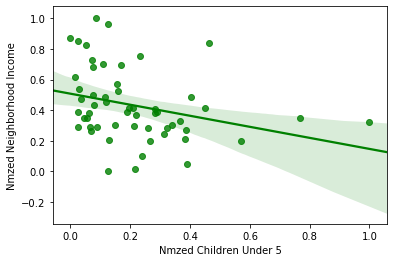

In [40]:
import seaborn as sns
ax = sns.regplot(x='Nmzed Children Under 5', y='Nmzed Neighborhood Income', data=c_n_i_mtx, color='green')

The relationship is not as straightforward as it looks on the map, but it sure seems like more children live in areas with middle income by area standards. My guess (also backed by superficial knowledge of the area) is that in terms of areas with smaller numbers of children, areas with higher incomes have more empty nesters, whereas the areas with lower income have a younger population. This hunch can be validate by demographic data, but it is beyond the scope of this analysis. 

Below is a list of 5 top neighborhoods

In [41]:
# sort dataframe on number of children under 5
ffx_neighborhoods_pop_char.sort_values(by='num_ch_u_five', ascending=False, inplace=True)

# get top 5 neighborhoods
children_n_income_top5 = ffx_neighborhoods_pop_char[['NAME','num_ch_u_five']].head()
children_n_income_top5=children_n_income_top5.set_index('NAME')
children_n_income_top5

num_ch_u_five
NAME                      
Centreville           5014
Reston                3896
Annandale             2947
McLean                2430
Oakton                2371

I also mark them to later see how the number of children under 5 alone would determine favorability

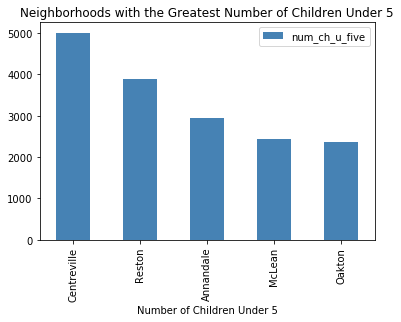

In [42]:
# generate plot
children_n_income_top5.plot(kind='bar', color='steelblue')
plt.xlabel('Number of Children Under 5')
plt.title('Neighborhoods with the Greatest Number of Children Under 5')

plt.show()


Do the same for income

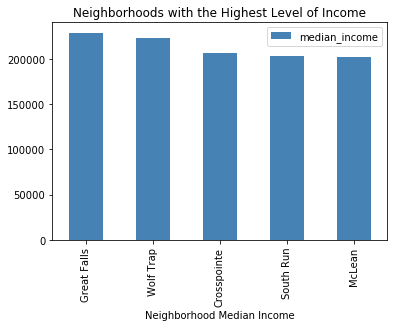

In [43]:
#Sort by income
ffx_neighborhoods_pop_char.sort_values(by='median_income', ascending=False, inplace=True)
# Get top 5 neighborhoods by median income
income_n_children_top5 = ffx_neighborhoods_pop_char[['NAME','median_income']].head()
income_n_children_top5=income_n_children_top5.set_index('NAME')

# Plot
income_n_children_top5.plot(kind='bar', color='steelblue')
plt.xlabel('Neighborhood Median Income')
plt.title('Neighborhoods with the Highest Level of Income')

plt.show()

## II.2. Foursquare Business Data

In [44]:
# Define Foursquare Credentials

CLIENT_ID = 'UWGKSIHG34HUV2XDBCPPP0GLOZU1MU5F3Z5M2ISCMJYZF4SX'
CLIENT_SECRET = 'ZWUXPZP2W3XY20JDNXQAGZ1CLEIUF1A5HLYCHBDUKNQEGKRQ'
VERSION = '20180605'
CATEGORIES = '4f4532974b9074f6e4fb0104' #A variable category for daycare centers

In [45]:
#Here I use the explore endpoint for the API call and return daycares near each latitude and longitude

def getNearbyVenues(geocodes, latitudes, longitudes, neighborhoods, categories=CATEGORIES, radius=5000):
    
    venues_list=[]
    for geoc, lat, lng, neigh in zip(geocodes,latitudes, longitudes, neighborhoods):
            
        # create the API request URL with the explore endpoint
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{},&categoryId={}&radius={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            categories,
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            geoc,
            lat, 
            lng,
            neigh,
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['GEOID', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Neighborhood',
                  'Daycare',
                  'd_id',         
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Type']
    
    return(nearby_venues)

In [46]:
#Use latitude and longitudes to obtain daycares in Fairfax County

ffx_dcs = getNearbyVenues(geocodes=ffx_neighborhoods_pop_char['GEOID'], latitudes=ffx_neighborhoods_pop_char['INTPTLAT'], longitudes=ffx_neighborhoods_pop_char['INTPTLON'], neighborhoods=ffx_neighborhoods_pop_char['NAME'])

In [47]:
ffx_dcs.shape

(615, 9)

In [48]:
#Take a look at a few rows of daycares
ffx_dcs.head()

GEOID  Neighborhood Latitude  Neighborhood Longitude Neighborhood  \
0  5132496              39.012386              -77.301969  Great Falls   
1  5132496              39.012386              -77.301969  Great Falls   
2  5187240              38.937348              -77.282859    Wolf Trap   
3  5187240              38.937348              -77.282859    Wolf Trap   
4  5187240              38.937348              -77.282859    Wolf Trap   

                                             Daycare  \
0                                 Kiddo Land Daycare   
1                          Primrose School of Reston   
2                                 The Goddard School   
3  Bright Horizons Early Education and Back-Up Ce...   
4                                 Kiddo Land Daycare   

                       d_id  Venue Latitude  Venue Longitude Venue Type  
0  5ba5b5e1acb00b002cb4e1ab       38.971373       -77.301373    Daycare  
1  5abeddd2c876c84471051561       38.984368       -77.341110    Daycare  
2  59d8437f59c423320c845eb5       38.929544       -77.249159    Daycare  
3  58b9aff315fb437fcfeb3cb8       38.928232       -77.237061    Daycare  
4  5ba5b5e1acb00b002cb4e1ab       38.971373       -77.301373    Daycare

In [49]:
#Not interested in daycares located in gyms
filt=ffx_dcs['Venue Type']=='Daycare'
ffx_dcs=ffx_dcs.loc[filt].reset_index(drop=True)
ffx_dcs.head()

GEOID  Neighborhood Latitude  Neighborhood Longitude Neighborhood  \
0  5132496              39.012386              -77.301969  Great Falls   
1  5132496              39.012386              -77.301969  Great Falls   
2  5187240              38.937348              -77.282859    Wolf Trap   
3  5187240              38.937348              -77.282859    Wolf Trap   
4  5187240              38.937348              -77.282859    Wolf Trap   

                                             Daycare  \
0                                 Kiddo Land Daycare   
1                          Primrose School of Reston   
2                                 The Goddard School   
3  Bright Horizons Early Education and Back-Up Ce...   
4                                 Kiddo Land Daycare   

                       d_id  Venue Latitude  Venue Longitude Venue Type  
0  5ba5b5e1acb00b002cb4e1ab       38.971373       -77.301373    Daycare  
1  5abeddd2c876c84471051561       38.984368       -77.341110    Daycare  
2  59d8437f59c423320c845eb5       38.929544       -77.249159    Daycare  
3  58b9aff315fb437fcfeb3cb8       38.928232       -77.237061    Daycare  
4  5ba5b5e1acb00b002cb4e1ab       38.971373       -77.301373    Daycare

In [50]:
ffx_dcs.shape

(566, 9)

In [51]:
#Get a count of daycares by neighborhoods
dc_counts_df=pd.DataFrame(ffx_dcs['GEOID'].value_counts()).reset_index().rename(columns={'index':'GEOID','GEOID':'num_dcs'})
dc_counts_df.head()

GEOID  num_dcs
0  5136648       22
1  5166672       20
2  5123392       15
3  5104088       15
4  5181072       15

In [52]:
#Add the number of daycares for each neighborhood to the neighborhood population characteristic
ffx_neighborhoods_pop_char= pd.merge(ffx_neighborhoods_pop_char,dc_counts_df[['GEOID','num_dcs']], how='left')
ffx_neighborhoods_pop_char.head()

GEOID         NAME   INTPTLAT   INTPTLON  \
0  5132496  Great Falls  39.012386 -77.301969   
1  5187240    Wolf Trap  38.937348 -77.282859   
2  5120436  Crosspointe  38.724980 -77.263232   
3  5174120    South Run  38.748317 -77.273197   
4  5148376       McLean  38.943545 -77.192913   

                                              coords  num_ch_u_five  \
0  [(-77.37097840599995, 39.01461679600004), (-77...            610   
1  [(-77.31701538699997, 38.97573379100004), (-77...            814   
2  [(-77.28118435999994, 38.726967742000056), (-7...            206   
3  [(-77.29794136699996, 38.75138574600004), (-77...            328   
4  [(-77.28777337699995, 38.966140790000054), (-7...           2430   

   working_f_ch_u_six  pct_all_parents_work  median_income  pop_total  num_dcs  
0                 829                  69.1         228836      12537        2  
1                1176                  73.0         222908      13456        7  
2                 259                  76.4         206250       4883        8  
3                 393                  80.2         203563       5035        9  
4                2964                  58.2         201570      37220        8

It makes more sense to express the number of daycares as a ratio of the target population. In other words, how many children per daycare. Similarly, I have to get the estimated number of families

In [53]:
#Add column with number of children under 5 per daycare
ffx_neighborhoods_pop_char['num_c_per_dayc']=(ffx_neighborhoods_pop_char['num_ch_u_five']/ffx_neighborhoods_pop_char['num_dcs']).astype('int')
#Add column with number of families with children under 6 in which all parents are working
ffx_neighborhoods_pop_char['num_f_c_u_w']=(ffx_neighborhoods_pop_char['pct_all_parents_work']*ffx_neighborhoods_pop_char['working_f_ch_u_six']/100).astype('int')
ffx_neighborhoods_pop_char.head()

GEOID         NAME   INTPTLAT   INTPTLON  \
0  5132496  Great Falls  39.012386 -77.301969   
1  5187240    Wolf Trap  38.937348 -77.282859   
2  5120436  Crosspointe  38.724980 -77.263232   
3  5174120    South Run  38.748317 -77.273197   
4  5148376       McLean  38.943545 -77.192913   

                                              coords  num_ch_u_five  \
0  [(-77.37097840599995, 39.01461679600004), (-77...            610   
1  [(-77.31701538699997, 38.97573379100004), (-77...            814   
2  [(-77.28118435999994, 38.726967742000056), (-7...            206   
3  [(-77.29794136699996, 38.75138574600004), (-77...            328   
4  [(-77.28777337699995, 38.966140790000054), (-7...           2430   

   working_f_ch_u_six  pct_all_parents_work  median_income  pop_total  \
0                 829                  69.1         228836      12537   
1                1176                  73.0         222908      13456   
2                 259                  76.4         206250       4883   
3                 393                  80.2         203563       5035   
4                2964                  58.2         201570      37220   

   num_dcs  num_c_per_dayc  num_f_c_u_w  
0        2             305          572  
1        7             116          858  
2        8              25          197  
3        9              36          315  
4        8             303         1725

# Part III. Clustering the Neighborhood

I use Agglomerative Clustering to put the neighborhoods into clusters. In general, I chose clustering because the question presented here is that of location segmentation. Specifically, I chose this type of clustering because of the size of the dataset. 

In [54]:
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

In [55]:
#Select features avoiding a few that appear repetitive
featureset = ffx_neighborhoods_pop_char[['num_ch_u_five','median_income','num_c_per_dayc','num_f_c_u_w']]

In [56]:
#Normalize the feature set to make sure they are in the same range
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
#Examine
feature_mtx [0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


array([[0.08402662, 1.        , 0.6713948 , 0.09960159],
       [0.12645591, 0.96556091, 0.22458629, 0.17556441],
       [0.        , 0.86878522, 0.00945626, 0.        ],
       [0.02537438, 0.85317493, 0.03546099, 0.0313413 ],
       [0.4625624 , 0.84159647, 0.66666667, 0.40584329]])

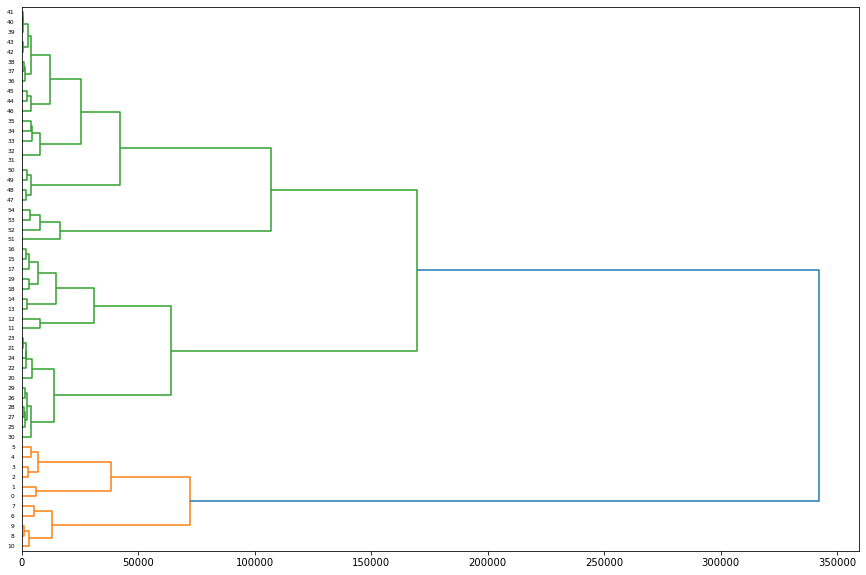

In [57]:
#Finding the optimal number of clusters
import scipy.cluster.hierarchy as sch
plt.figure(figsize=(15, 10))
dendrogram = sch.dendrogram(sch.linkage(x, method ='ward'), orientation='right')

#### Looking at the data and the dendrogram, the optimal number of clusters appears to be 4. Now I use AgglomerativeClustering and test it on different types of linkages to see which algorithm performs the best. 

In [58]:
agglom = AgglomerativeClustering(n_clusters = 4, affinity ='euclidean', linkage = 'ward')
agglom.fit(feature_mtx)
#Obtain the labels for the rows
agglom.labels_

array([3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 0, 2,
       1, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2,
       1, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2])

In [59]:
#Label the population characteristics dataset
ffx_neighborhoods_pop_char['clusters_'] = agglom.labels_
ffx_neighborhoods_pop_char.head()


GEOID         NAME   INTPTLAT   INTPTLON  \
0  5132496  Great Falls  39.012386 -77.301969   
1  5187240    Wolf Trap  38.937348 -77.282859   
2  5120436  Crosspointe  38.724980 -77.263232   
3  5174120    South Run  38.748317 -77.273197   
4  5148376       McLean  38.943545 -77.192913   

                                              coords  num_ch_u_five  \
0  [(-77.37097840599995, 39.01461679600004), (-77...            610   
1  [(-77.31701538699997, 38.97573379100004), (-77...            814   
2  [(-77.28118435999994, 38.726967742000056), (-7...            206   
3  [(-77.29794136699996, 38.75138574600004), (-77...            328   
4  [(-77.28777337699995, 38.966140790000054), (-7...           2430   

   working_f_ch_u_six  pct_all_parents_work  median_income  pop_total  \
0                 829                  69.1         228836      12537   
1                1176                  73.0         222908      13456   
2                 259                  76.4         206250       4883   
3                 393                  80.2         203563       5035   
4                2964                  58.2         201570      37220   

   num_dcs  num_c_per_dayc  num_f_c_u_w  clusters_  
0        2             305          572          3  
1        7             116          858          0  
2        8              25          197          0  
3        9              36          315          0  
4        8             303         1725          3

### III.3. Cluster Characteristics

In [60]:
agg_neighborhoods = (ffx_neighborhoods_pop_char.groupby(['clusters_'])['num_ch_u_five','median_income','num_f_c_u_w','num_c_per_dayc'].mean()).astype('int')
agg_neighborhoods

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


num_ch_u_five  median_income  num_f_c_u_w  num_c_per_dayc
clusters_                                                           
0                    535         148496          453              50
1                   3072         115129         2469             282
2                   1386         107936         1040             148
3                   1457         205779         1210             350

- Cluster 0: Neighborhoods have a small number of children, incomes above the area average, a small number of families with children under 5 where both parents are working, and the number of childcares appears sufficient. All things being equal, neighborhoods in this cluster would not be on the top of the list for consideration.

- Cluster 1: Neighborhoods have the highest number of children under 5, incomes in the below area average and median, the highest number of families with both parents working and a high density of children under 5 per daycare. This area would be very attractive especially for someone interested in finding opportunities to serve low income working families.

- Cluster 2: Neighborhoods have a relatively smaller number of children, the lowest level of income, a relatively smaller number of working families with children, and a smaller number of children per daycare compared to cluster 2. I would choose cluster 2 over cluster 3 because they are almost similar in terms of income level but cluster 2 has a higher density of children (almost double) in daycare by comparison.

- Cluster 3: Neighborhoods have a number of children under 5 toward the averge, by far the highest level income, the second highest number of working families with children under 6 where all parents are working, and the highest density of children under five per daycare. At first glance, this area presents a good opportunity for someone whose highest priority is financial stability, although, of course, given the high area income, start up costs may be high, including the unavailability of real estate. 
 

### III.3.1. Choosing the Priority Neighborhood

In the section above, neighborhoods were dvided into 4 clusters. I further identified two clusters of neighborhoods that appear to present the best opportunity (cluster 1 and 3) for a businessperson given the businessperson priority. In this section, I explore the two priority clusters to recommend one neighborhood within each. This selection would simply be based on the number of children by number of daycares in and around the neighborhood. 

In [61]:
#Examine neighborhoods in cluster 1 
low_income_priority= ffx_neighborhoods_pop_char[ffx_neighborhoods_pop_char.clusters_==1].reset_index(drop=True)
low_income_priority

GEOID               NAME   INTPTLAT   INTPTLON  \
0  5111464              Burke  38.777769 -77.262617   
1  5158472             Oakton  38.889444 -77.302226   
2  5166672             Reston  38.948449 -77.342215   
3  5114440        Centreville  38.840650 -77.438462   
4  5184368  West Falls Church  38.865559 -77.187699   
5  5101912          Annandale  38.832801 -77.196229   

                                              coords  num_ch_u_five  \
0  [(-77.30126837099994, 38.79752775500003), (-77...           2149   
1  [(-77.33867038799997, 38.877674770000056), (-7...           2371   
2  [(-77.39326140899993, 38.94523878200005), (-77...           3896   
3  [(-77.47956242999999, 38.86152976200003), (-77...           5014   
4  [(-77.22043935099998, 38.87583577400005), (-77...           2056   
5  [(-77.22214534799997, 38.820930763000035), (-7...           2947   

   working_f_ch_u_six  pct_all_parents_work  median_income  pop_total  \
0                2601                  77.0         140229      34540   
1                2926                  63.2         128504      29911   
2                4540                  64.7         116375      49986   
3                5932                  66.8         112174      59921   
4                2369                  68.8         102952      23824   
5                3311                  73.6          90545      35586   

   num_dcs  num_c_per_dayc  num_f_c_u_w  clusters_  
0        9             238         2002          1  
1        8             296         1849          1  
2       20             194         2937          1  
3       12             417         3962          1  
4        8             257         1629          1  
5       10             294         2436          1

Clearly **Centerville** presents the best opportunity with a small number of daycares, highest number of children per daycare, and a very high number of families with both parents working. 

In [62]:
#Examine neighborhoods in cluster 2 
high_income_priority= ffx_neighborhoods_pop_char[ffx_neighborhoods_pop_char.clusters_==3].reset_index(drop=True)
high_income_priority

GEOID         NAME   INTPTLAT   INTPTLON  \
0  5132496  Great Falls  39.012386 -77.301969   
1  5148376       McLean  38.943545 -77.192913   
2  5129136    Fort Hunt  38.735462 -77.057664   

                                              coords  num_ch_u_five  \
0  [(-77.37097840599995, 39.01461679600004), (-77...            610   
1  [(-77.28777337699995, 38.966140790000054), (-7...           2430   
2  [(-77.08219029899999, 38.72865875000008), (-77...           1332   

   working_f_ch_u_six  pct_all_parents_work  median_income  pop_total  \
0                 829                  69.1         228836      12537   
1                2964                  58.2         201570      37220   
2                1656                  80.6         186931      12885   

   num_dcs  num_c_per_dayc  num_f_c_u_w  clusters_  
0        2             305          572          3  
1        8             303         1725          3  
2        3             444         1334          3

In this cluster, Fort Hunt comes on top with the highest number of children per daycare and the heighest percentage of families with children under 6 with all parents working. 

## Part IV. Conclusion

In this project, I have shown how a businessperson can take advantage of data science techniques to solve the most pressing problem for anyone trying to start a new in-person business: where should the new business be located? Inspired by the CRISP-DM methodology, I used daycare as a case study to create a roadmap for solving this problem. My objective was to conduct an analysis that leaves a manageable number of neighborhoods with which the businessperson can start. After defining this objective, I collected demographic and geospatial data in different formats from the Census Bureau and Fairfax County websites. I combined this data with daycare location data using Foursquare API, and prepared it for modeling. A model was generated using agglomerative clustering, and I deployed it to create four clusters of smilar neighborhoods from which two clusters and one neighborhood from each of the two clusters was chosen.  

The analysis presented here was exploratory in nature and the model obtained should be further evaluated. However, even in this preliminary stage, my objective was achieve and the business question was answered. The success of this analysis is three-fold:

 1. Two priority neighborhoods, namely, **Centreville** and **Fort Hunt**, emerged. This reduces the amount of work necessary for location exploration. With further model evaluation of this and other algorithms, an even more tight model may emerge with even more actionable clusters. 
 2. The analysis clearly points to areas for further market research opportunities. New data such as data on recent marriage licenses and additional age groups, can help identify even more areas of opportunity. Business license data would show how successful daycares in given neighborhoods have been, which can further enhance similarity measurement within neighborhood clusters.
 3. This work shows that data science is not just for big businesses and big data: even small businesses and individuals can benefit from data science and recent advances in machine learning.


With decennial census data coming in the next few months, building on this inquiry will help any new business, especially small businesses without resources to develop expensive analytical capabilities. 